Autor: Nathan Torquato Mimoso (Hash 71)

## <center>PMR3508 - Tarefa 2: Comparação de três classificadores na base *Adult*</center>

Nesta tarefa serão testadas **três técnicas de classificação** na base *Adult*, comparando-se em seguida o desempenho de cada uma delas.
As técnicas escolhidas foram:
- Regressão logística
- Árvores de Classificação e Random forests
- SVM  

Como métricas de desempenho foram adotados:
* Acurácia
* Precisão
* F1-Score
* Recall

### 1. Importando as ferramentas e os dados

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import sklearn

#Importando as bibliotecas com as métricas
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/californiahousing/test.csv
/kaggle/input/californiahousing/train.csv
/kaggle/input/shapefile-california/CA_Counties_TIGER2016.dbf
/kaggle/input/shapefile-california/CA_Counties_TIGER2016.cpg
/kaggle/input/shapefile-california/CA_Counties_TIGER2016.shp
/kaggle/input/shapefile-california/CA_Counties_TIGER2016.prj
/kaggle/input/shapefile-california/CA_Counties_TIGER2016.shx
/kaggle/input/shapefile-california/CA_Counties_TIGER2016.sbn
/kaggle/input/shapefile-california/CA_Counties_TIGER2016.sbx
/kaggle/input/shapefile-california/CA_Counties_TIGER2016.shp.xml
/kaggle/input/adult-pmr3508/Extra-file-from-UCI.txt
/kaggle/input/adult-pmr3508/train_data.csv
/kaggle/input/adult-pmr3508/test_data.csv
/kaggle/input/adult-pmr3508/sample_submission.csv


In [2]:
#Importando a base de treino
train = pd.read_csv("/kaggle/input/adult-pmr3508/train_data.csv", engine='python', na_values="?")
train.set_index('Id', inplace=True)
train.columns = ["Age", "Workclass", "fnlwgt", "Education", "Education_num", "Marital_status", "Occupation", "Relationship", "Race", "Sex", "Capital_gain", "Capital_loss", "Hours_per_week", "Native_country", "Income"]
train.head()

,Age,Workclass,fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
Id,,,,,,,,,,,,,,,
16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


In [3]:
#Importando a base de testes
test = pd.read_csv("/kaggle/input/adult-pmr3508/test_data.csv", engine='python', na_values="?")
test.set_index('Id', inplace=True)
test.columns = ["Age", "Workclass", "fnlwgt", "Education", "Education_num", "Marital_status", "Occupation", "Relationship", "Race", "Sex", "Capital_gain", "Capital_loss", "Hours_per_week", "Native_country"]
test.head()

,Age,Workclass,fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country
Id,,,,,,,,,,,,,,
0,25,Private,120596,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,44,United-States
1,64,State-gov,152537,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
2,31,Private,100135,Masters,14,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States
3,45,Private,189123,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,40,United-States
4,64,Self-emp-inc,487751,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States


### 2. Rápido tratamento dos dados

Como a Análise Exploratória deste conjunto de dados já foi realizada no primeiro trabalho da disciplina (e se encontra disponível em https://www.kaggle.com/nathanmimoso/pmr3508-2019-71 ), partiremos de seus resultados.
Além disso, repetiremos alguns dos métodos outrora utilizados: excluíremos as linhas com *missing values* e transformaremos todas as entradas da base de dados em valores numéricos. Por fim, também normalizaremos as variáveis.

In [4]:
#Importando algumas bibliotecas para esta etapa
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [5]:
train = train.dropna()
Xtrain_0 = train[["Age", "Workclass", "fnlwgt", "Education", "Education_num", "Marital_status", "Occupation", "Relationship", "Race", "Sex", "Capital_gain", "Capital_loss", "Hours_per_week", "Native_country"]]
Xtrain_1 = Xtrain_0.apply(preprocessing.LabelEncoder().fit_transform)
scaler = StandardScaler()
Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain_1), columns=Xtrain_0.columns)
Ytrain = train[['Income']]

test = test.dropna()
Xtest_0 = test.apply(preprocessing.LabelEncoder().fit_transform)
Xtest = pd.DataFrame(scaler.transform(Xtest_0), columns=Xtest_0.columns)

Vemos, a seguir, que as variáveis mais correlacionadas com a *feature Income* são *Education_num*, *Capital_gain*, *Relationship*, *Age*, *Hours_per_week* e *Sex*.

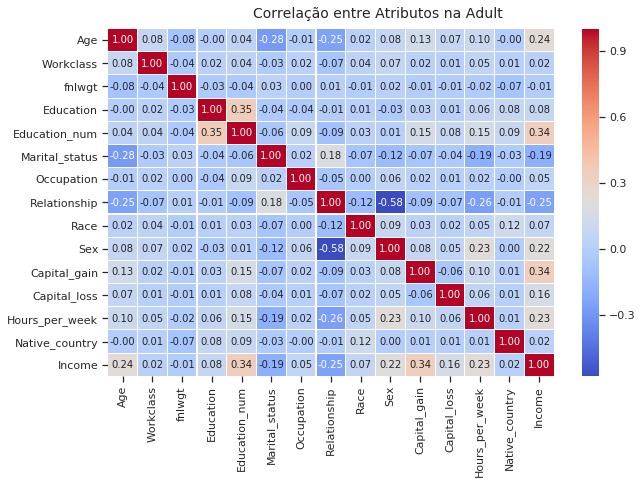

In [6]:
train_num = train.apply(preprocessing.LabelEncoder().fit_transform)
f, ax = plt.subplots(figsize=(10, 6))
corr = train_num.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t = f.suptitle('Correlação entre Atributos na Adult', fontsize=14)

Assim, para evitar *overfitting* e para simplificar a modelagem, trabalharemos apenas com as variáveis selecionadas abaixo (as 8 de maior correlação com a variável resposta).

In [7]:
Xtrain = Xtrain[['Age', 'Education_num', 'Marital_status',
                 'Relationship', 'Sex', 'Capital_gain', 'Capital_loss', 'Hours_per_week']]
Xtest = Xtest[['Age', 'Education_num', 'Marital_status',
                 'Relationship', 'Sex', 'Capital_gain', 'Capital_loss', 'Hours_per_week']]

Antes de passar a modelagem em si, cabe relembrar os resultados obtidos com o classificador kNN: foi escolhido **k = 26** via *cross validation* e a acurácia média obtida foi de **0.830973965155016**.

### 3. Regressão Logística ###

O primeiro modelo a ser testado é a regressão logística, caracterizada por ser um classificador com fronteira linear.

In [8]:
#Importando as bibliotecas necessárias
import sklearn.linear_model as linear_model

logistic = linear_model.LogisticRegression()

logistic_scores = cross_validate(logistic, Xtrain, Ytrain, cv=10, scoring=('accuracy', 'f1_macro', 'precision_macro', 'recall_macro'))
logistic_scores

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:43

{'fit_time': array([0.13822222, 0.1422286 , 0.14457655, 0.14100671, 0.14295983,
        0.14296889, 0.14166999, 0.14857817, 0.14700913, 0.1426127 ]),
 'score_time': array([0.21163845, 0.20475936, 0.21270633, 0.21059561, 0.21228242,
        0.21105623, 0.21061087, 0.21256876, 0.20617199, 0.21269011]),
 'test_accuracy': array([0.81571097, 0.81504806, 0.82698044, 0.81233422, 0.816313  ,
        0.81498674, 0.81233422, 0.8229443 , 0.82620232, 0.82189055]),
 'test_f1_macro': array([0.71815412, 0.71781279, 0.73151993, 0.71642363, 0.71914381,
        0.72043178, 0.70922148, 0.73760479, 0.73273158, 0.7235891 ]),
 'test_precision_macro': array([0.76852707, 0.76678482, 0.7935714 , 0.76006968, 0.76971144,
        0.76478198, 0.76537889, 0.77467281, 0.78905174, 0.78357044]),
 'test_recall_macro': array([0.69570552, 0.69570934, 0.70543336, 0.69570874, 0.69657763,
        0.69925486, 0.68636314, 0.71745869, 0.70774393, 0.69863135])}

In [9]:
print("Acurácia média: ", logistic_scores['test_accuracy'].mean(), "\nF1-Score médio: ", logistic_scores['test_f1_macro'].mean(), "\nPrecisão média: ", logistic_scores['test_precision_macro'].mean(), "\nRecall médio: ", logistic_scores['test_recall_macro'].mean())

Acurácia média:  0.8184744812132854 
F1-Score médio:  0.722663301965461 
Precisão média:  0.7736120275412545 
Recall médio:  0.6998586553904753


A acurácia obtida é baixa, menor que a encontrada outrora no kNN. Isso pode ser um indicativo de que a fronteira que delimita as classes do problema não é muito bem aproximada por uma fronteira linear. Como ainda testaremos outro classificador linear, tal hipótese pode ser refutada ou endossada por ele.

### 4. Árvores de Classificação, Boosting e Random Forests ###

Os três classificadores foram agrupados aqui, apesar de não se tratarem da mesma ferramenta, por algumas semelhanças entre eles e por, muitas vezes, serem aplicados conjuntamente.
As árvores de decisão (neste caso, de classificação) são classificadores muito simples e de fácil interpretabilidade. A seguir, fazemos um ajuste inicial muito simples apenas para medir sua acurácia.

In [10]:
#importando as bibliotecas necessárias
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion="gini")

tree_scores = cross_validate(tree, Xtrain, Ytrain, cv=10, scoring=('accuracy', 'f1_macro', 'precision_macro', 'recall_macro'))
tree_scores

{'fit_time': array([0.13255954, 0.13199329, 0.13275146, 0.12981772, 0.13307238,
        0.13069701, 0.1322875 , 0.13394499, 0.13046408, 0.16366339]),
 'score_time': array([0.1387372 , 0.13734651, 0.13728023, 0.14185071, 0.13657165,
        0.14318633, 0.13672805, 0.14349532, 0.18149137, 0.19390988]),
 'test_accuracy': array([0.82399735, 0.81968843, 0.82300298, 0.82625995, 0.82128647,
        0.82460212, 0.82427056, 0.8219496 , 0.82421227, 0.82752902]),
 'test_f1_macro': array([0.75771668, 0.75095113, 0.75646405, 0.7550696 , 0.74664891,
        0.75433564, 0.74763546, 0.75353684, 0.7575434 , 0.75788877]),
 'test_precision_macro': array([0.76618059, 0.76028057, 0.76473386, 0.7719196 , 0.76509005,
        0.76870984, 0.7713807 , 0.7637574 , 0.76648829, 0.7730396 ]),
 'test_recall_macro': array([0.75063082, 0.74331107, 0.74952373, 0.74280768, 0.73371105,
        0.74348404, 0.73213758, 0.74527826, 0.75011921, 0.7465298 ])}

In [11]:
print("Acurácia média: ", tree_scores['test_accuracy'].mean(), "\nF1-Score médio: ", tree_scores['test_f1_macro'].mean(), "\nPrecisão média: ", tree_scores['test_precision_macro'].mean(), "\nRecall médio: ", tree_scores['test_recall_macro'].mean())

Acurácia média:  0.8236798757470114 
F1-Score médio:  0.7537790468222758 
Precisão média:  0.7671580498700549 
Recall médio:  0.7437533218299477


Agora, queremos escolher qual método de avaliação de *splits* usar (*Gini index* ou Entropia) e também limitaremos a profundidade da árvore, visando evitar *overfitting*.

In [12]:
results = []
for i in range(1,20):
    tree = DecisionTreeClassifier(criterion="gini",max_depth=i)
    tree_scores = cross_val_score(tree, Xtrain, Ytrain, cv=10)
    results.append(tree_scores.mean())
print(results)

[0.7510692724096513, 0.8216897052163276, 0.8359133711580057, 0.8422129413492693, 0.8451968614690349, 0.8491426500094894, 0.8520604330503421, 0.8523590174495501, 0.8535857859571487, 0.8525577915276286, 0.8515633274644623, 0.8493754820051013, 0.8476514979179491, 0.8454300893995891, 0.8449657773544013, 0.8408877145905093, 0.8375722295058766, 0.8367433279122812, 0.8338917259828037]


In [13]:
results = []
for i in range(1,20):
    tree = DecisionTreeClassifier(criterion="entropy",max_depth=i)
    tree_scores = cross_val_score(tree, Xtrain, Ytrain, cv=10)
    results.append(tree_scores.mean())
print(results)

[0.7510692724096513, 0.8216897052163276, 0.8358802256492222, 0.8406216711905137, 0.843041996779457, 0.8467554698345581, 0.8508669089459582, 0.8512980424179201, 0.8527899420261168, 0.8515630635758754, 0.8494082427656664, 0.8501046941153284, 0.8476511790872013, 0.8455627152849319, 0.8441701202223417, 0.842777371454382, 0.8387989650073541, 0.8383679965587086, 0.8371744944341051]


O melhor resultado foi obtido para árvores com *max_depth* = 9 e *splits* escolhidos através de *Gini index*.

In [14]:
tree = DecisionTreeClassifier(criterion="gini", max_depth=9)

tree_scores = cross_validate(tree, Xtrain, Ytrain, cv=10, scoring=('accuracy', 'f1_macro', 'precision_macro', 'recall_macro'))
tree_scores

{'fit_time': array([0.10434794, 0.10768509, 0.1040554 , 0.10207462, 0.10402751,
        0.10717034, 0.1047895 , 0.10415339, 0.10325599, 0.10430646]),
 'score_time': array([0.14165854, 0.13546634, 0.13419914, 0.13415694, 0.13444734,
        0.13521361, 0.13483405, 0.13825321, 0.13536835, 0.13841462]),
 'test_accuracy': array([0.8568114 , 0.85515413, 0.84885648, 0.85676393, 0.85179045,
        0.85245358, 0.85079576, 0.85278515, 0.85041459, 0.85771144]),
 'test_f1_macro': array([0.78962252, 0.78540807, 0.7693954 , 0.78406286, 0.77406138,
        0.77795083, 0.77267977, 0.78231615, 0.77467641, 0.7856678 ]),
 'test_precision_macro': array([0.82884253, 0.82881943, 0.82841099, 0.83808108, 0.83358295,
        0.82982911, 0.83153946, 0.82433551, 0.82612938, 0.83896943]),
 'test_recall_macro': array([0.76624371, 0.76068919, 0.74091738, 0.75599627, 0.74511953,
        0.75090137, 0.74401225, 0.75824258, 0.74793819, 0.75769978])}

In [15]:
print("Acurácia média: ", tree_scores['test_accuracy'].mean(), "\nF1-Score médio: ", tree_scores['test_f1_macro'].mean(), "\nPrecisão média: ", tree_scores['test_precision_macro'].mean(), "\nRecall médio: ", tree_scores['test_recall_macro'].mean())

Acurácia média:  0.8533536904518524 
F1-Score médio:  0.7795841199834113 
Precisão média:  0.8308539873798277 
Recall médio:  0.7527760257516566


Este resultado já melhora aquele obtido com kNN no trabalho anterior.  
Agora vamos testar uma *Boosted tree* utilizado o algoritmo AdaBoost.

In [16]:
#importando as bibliotecas necessárias
from sklearn.ensemble import AdaBoostClassifier

boosted_tree = AdaBoostClassifier(n_estimators=200)

boosted_scores = cross_validate(boosted_tree, Xtrain, Ytrain, cv=10, scoring=('accuracy', 'f1_macro', 'precision_macro', 'recall_macro'))
boosted_scores

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

{'fit_time': array([14.55497766, 14.56056333, 14.58682656, 14.47205806, 14.67058635,
        14.63723516, 14.6597662 , 14.72716236, 14.62251425, 14.56750202]),
 'score_time': array([0.57590127, 0.56990314, 0.56793189, 0.56394196, 0.57198429,
        0.56604719, 0.56728458, 0.57457328, 0.56418848, 0.58151436]),
 'test_accuracy': array([0.85846868, 0.86310905, 0.85614849, 0.85875332, 0.85477454,
        0.85742706, 0.85676393, 0.85775862, 0.85638474, 0.85605307]),
 'test_f1_macro': array([0.79419773, 0.80428702, 0.78794701, 0.79715605, 0.78691536,
        0.7905772 , 0.78748688, 0.79604838, 0.79325995, 0.78860959]),
 'test_precision_macro': array([0.82830926, 0.83069144, 0.82882041, 0.82527341, 0.82518814,
        0.82991167, 0.8321705 , 0.82329472, 0.82187338, 0.82717763]),
 'test_recall_macro': array([0.77268849, 0.78601553, 0.7640219 , 0.77823711, 0.76401737,
        0.76711846, 0.76222667, 0.77757486, 0.77420751, 0.76551435])}

In [17]:
print("Acurácia média: ", boosted_scores['test_accuracy'].mean(), "\nF1-Score médio: ", boosted_scores['test_f1_macro'].mean(), "\nPrecisão média: ", boosted_scores['test_precision_macro'].mean(), "\nRecall médio: ", boosted_scores['test_recall_macro'].mean())

Acurácia média:  0.8575641482623622 
F1-Score médio:  0.7926485171928248 
Precisão média:  0.8272710547170522 
Recall médio:  0.7711622238976837


Algumas métricas de desempenho (acurácia, F1-Score e recall) experimentaram uma pequena melhora e ela só ocorreu quando *n_estimators* (número de *stumps*) foi suficientemente grande. Todavia, o custo computacional para isso foi grande, a melhora não foi significativa e a precisão diminuiu.  
Por fim, testamos Random Forests, que é um tipo de estratégia de *Bootstrap/Bagging*, isto é, elas operam construindo várias árvores de decisão no momento do treinamento e retornam a classe que é a moda das classes (já que trata-se de um problema de classificação) das árvores individuais. As *random forests* minimizam a tendência de *overfitting* das árvores de decisão a sua base de treino.

In [18]:
#importando as bibliotecas necessárias
from sklearn.ensemble import RandomForestClassifier

random = RandomForestClassifier(n_estimators=100)

random_scores = cross_validate(random, Xtrain, Ytrain, cv=10, scoring=('accuracy', 'f1_macro', 'precision_macro', 'recall_macro'))
random_scores

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 

{'fit_time': array([2.50795293, 2.49299598, 2.49170232, 2.46346569, 2.41950655,
        2.45321536, 2.46972203, 2.45893526, 2.47296977, 2.45923328]),
 'score_time': array([0.45040321, 0.45238352, 0.45847464, 0.44646144, 0.45160031,
        0.45076108, 0.44793606, 0.45635748, 0.45386553, 0.44926071]),
 'test_accuracy': array([0.83559828, 0.83162082, 0.83725555, 0.8428382 , 0.83753316,
        0.83852785, 0.84383289, 0.8418435 , 0.83615257, 0.84212272]),
 'test_f1_macro': array([0.77314414, 0.76492736, 0.77312916, 0.77821713, 0.76979825,
        0.77201928, 0.77608108, 0.78000736, 0.76976422, 0.77859611]),
 'test_precision_macro': array([0.7829269 , 0.7785719 , 0.78661619, 0.79692205, 0.7896389 ,
        0.79053829, 0.80161114, 0.79306562, 0.78596441, 0.79449667]),
 'test_recall_macro': array([0.76503056, 0.75437046, 0.76257282, 0.76452589, 0.75565354,
        0.75854093, 0.75895774, 0.769649  , 0.75762031, 0.7664989 ])}

In [19]:
print("Acurácia média: ", random_scores['test_accuracy'].mean(), "\nF1-Score médio: ", random_scores['test_f1_macro'].mean(), "\nPrecisão média: ", random_scores['test_precision_macro'].mean(), "\nRecall médio: ", random_scores['test_recall_macro'].mean())

Acurácia média:  0.8387325530718345 
F1-Score médio:  0.7735684092595365 
Precisão média:  0.7900352052715187 
Recall médio:  0.7613420144821429


Esperava-se que o resultado obtido fosse melhor que o anterior, mas não foi isso que ocorreu. Entretanto, as *random forests* se saíram melhores que a regressão logística e o kNN.

### 5. SVM ###

*Support Vector Machine* é mais um classificador de fronteira linear. Ele constrói uma representação das observações como pontos no espaço, mapeados para que as observações das classes distintas sejam divididos por uma fronteira clara e o mais ampla possível. Novas entradas são mapeadas no mesmo espaço e prevê-se que pertençam a uma classe a partir do lado da fronteira em que caem.

In [20]:
#importando as bibliotecas necessárias
from sklearn.svm import SVC

svm = SVC()

svm_scores = cross_validate(svm, Xtrain, Ytrain, cv=10, scoring=('accuracy', 'f1_macro', 'precision_macro', 'recall_macro'))
svm_scores

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better 

{'fit_time': array([17.36548448, 17.46881342, 17.0603888 , 17.57569671, 17.17443562,
        17.25229669, 17.30127668, 17.31010723, 17.08003974, 17.03643465]),
 'score_time': array([4.13401318, 4.13468051, 4.12260771, 4.13455105, 4.13447571,
        4.1366117 , 4.1738224 , 4.15059543, 4.1459527 , 4.12344813]),
 'test_accuracy': array([0.84819357, 0.85051376, 0.84123301, 0.84416446, 0.84880637,
        0.84648541, 0.84250663, 0.84814324, 0.84742952, 0.85505804]),
 'test_f1_macro': array([0.77889896, 0.77728264, 0.76100639, 0.77033633, 0.77337717,
        0.77261994, 0.75990863, 0.77545224, 0.77394616, 0.78366695]),
 'test_precision_macro': array([0.81219564, 0.82281534, 0.81004564, 0.80892115, 0.82202978,
        0.8142568 , 0.81669227, 0.81654155, 0.81555018, 0.83093621]),
 'test_recall_macro': array([0.7582811 , 0.75225854, 0.73584235, 0.74805278, 0.74758306,
        0.74915301, 0.73270812, 0.75203687, 0.7504106 , 0.75771744])}

In [21]:
print("Acurácia média: ", svm_scores['test_accuracy'].mean(), "\nF1-Score médio: ", svm_scores['test_f1_macro'].mean(), "\nPrecisão média: ", svm_scores['test_precision_macro'].mean(), "\nRecall médio: ", svm_scores['test_recall_macro'].mean())

Acurácia média:  0.8472534001069001 
F1-Score médio:  0.7726495406285996 
Precisão média:  0.8169984568834125 
Recall médio:  0.7484043866234386


A acurácia obtida também foi maior que no kNN e na regressão logística, mas foi inferior aos métodos da seção anterior. Como dito no início, o desempenho não tão bom deste classificador pode estar indicando que a fronteira que separa as classes não é linear, já que ambos os classificadores que assim procediam não foram tão bem sucedidos.

### 6. Análise comparativa dos resultados ###

In [22]:
lr = pd.Series({'Classificador': 'Regressão logística', 'Acurácia': logistic_scores['test_accuracy'].mean(), 'F1-Score': logistic_scores['test_f1_macro'].mean(), 'Precisão': logistic_scores['test_precision_macro'].mean(), 'Recall': logistic_scores['test_recall_macro'].mean()})
t = pd.Series({'Classificador': 'Árvore de classificação', 'Acurácia': tree_scores['test_accuracy'].mean(), 'F1-Score': tree_scores['test_f1_macro'].mean(), 'Precisão': tree_scores['test_precision_macro'].mean(), 'Recall': tree_scores['test_recall_macro'].mean()})
bt = pd.Series({'Classificador': 'Boosted tree', 'Acurácia': boosted_scores['test_accuracy'].mean(), 'F1-Score': boosted_scores['test_f1_macro'].mean(), 'Precisão': boosted_scores['test_precision_macro'].mean(), 'Recall': boosted_scores['test_recall_macro'].mean()})
s = pd.Series({'Classificador': 'SVM', 'Acurácia': svm_scores['test_accuracy'].mean(), 'F1-Score': svm_scores['test_f1_macro'].mean(), 'Precisão': svm_scores['test_precision_macro'].mean(), 'Recall': svm_scores['test_recall_macro'].mean()}) 

relat = pd.DataFrame([lr, t, bt, s])
relat

,Classificador,Acurácia,F1-Score,Precisão,Recall
0,Regressão logística,0.818474,0.722663,0.773612,0.699859
1,Árvore de classificação,0.853354,0.779584,0.830854,0.752776
2,Boosted tree,0.857564,0.792649,0.827271,0.771162
3,SVM,0.847253,0.772650,0.816998,0.748404


É perceptível que os piores resultados foram os dos classificadores lineares, enquanto as árvores de classificação se saíram melhor (e, em destaque, a *boosted tree* obteve o melhor desempenho, por pequena margem), já que conseguem se adaptar bem a fronteiras flexíveis.

In [23]:
#gerando arquivo para submeter na competição
boosted_tree.fit(Xtrain, Ytrain)

test = pd.read_csv("/kaggle/input/adult-pmr3508/test_data.csv", engine='python')
test.set_index('Id', inplace=True)
test.columns = ["Age", "Workclass", "fnlwgt", "Education", "Education_num", "Marital_status", "Occupation", "Relationship", "Race", "Sex", "Capital_gain", "Capital_loss", "Hours_per_week", "Native_country"]
Xtest_0 = test.apply(preprocessing.LabelEncoder().fit_transform)
Xtest = pd.DataFrame(scaler.transform(Xtest_0), columns=Xtest_0.columns)
Xtest = Xtest[['Age', 'Education_num', 'Marital_status',
                 'Relationship', 'Sex', 'Capital_gain', 'Capital_loss', 'Hours_per_week']]

Ypred = boosted_tree.predict(Xtest)
Ypred

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['<=50K', '>50K', '<=50K', ..., '<=50K', '<=50K', '>50K'],
      dtype=object)

In [24]:
#gerando arquivo para submeter na competição
id_index = pd.DataFrame({'Id' : list(range(len(Ypred)))})
income = pd.DataFrame({'income' : Ypred})
result = id_index.join(income)
result.head()

,Id,income
0,0,<=50K
1,1,>50K
2,2,<=50K
3,3,<=50K
4,4,>50K


In [25]:
#gerando arquivo para submeter na competição
result.to_csv("submission.csv", index = False)

## <center>Tarefa extra: Regressão na base *CaliforniaHousing*</center>

Nesta tarefa extra, objetiva-se produzir *um regressor* para prever o preço de uma casa.

### 1. Importando e conhecendo os dados (*Exploratory Data Analysis*)

In [26]:
df = pd.read_csv('/kaggle/input/californiahousing/train.csv', engine='python', na_values='?')
df.set_index('Id', inplace=True)
df.head()

,longitude,latitude,median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
Id,,,,,,,,,
15817,-120.85,37.57,27,819,157,451,150,34934,193800
6236,-117.74,34.06,48,2438,599,1508,548,28983,129200
19262,-118.11,33.92,32,1016,190,729,177,43000,151300
19743,-118.12,34.15,35,1760,447,984,384,34167,198200
7272,-120.63,37.41,27,2083,444,1462,479,26439,69100


In [27]:
df.shape

(14448, 9)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14448 entries, 15817 to 9756
Data columns (total 9 columns):
longitude             14448 non-null float64
latitude              14448 non-null float64
median_age            14448 non-null int64
total_rooms           14448 non-null int64
total_bedrooms        14448 non-null int64
population            14448 non-null int64
households            14448 non-null int64
median_income         14448 non-null int64
median_house_value    14448 non-null int64
dtypes: float64(2), int64(7)
memory usage: 1.1 MB


In [29]:
df.isnull().sum()

longitude             0
latitude              0
median_age            0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

Vemos que esta é uma base de dados com 9 *features* e 14.448 entradas. Além disso, não há *missing values* nela. Abaixo apresentamos sua descrição estatística.

In [30]:
df.describe()

,longitude,latitude,median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000
mean,-119.563050,35.625804,28.700028,2622.627284,535.628391,1413.978405,496.934109,38747.577450,207556.603267
std,2.008096,2.138690,12.587508,2145.423570,416.800426,1095.060629,376.873380,19091.513037,116441.436255
min,-124.350000,32.550000,1.000000,2.000000,2.000000,3.000000,2.000000,4999.000000,14999.000000
25%,-121.790000,33.930000,18.000000,1444.000000,295.000000,784.000000,279.000000,25596.500000,119300.000000
50%,-118.490000,34.250000,29.000000,2116.000000,432.000000,1160.000000,407.000000,35334.000000,179950.000000
75%,-118.000000,37.710000,37.000000,3131.250000,645.250000,1705.000000,602.000000,47500.000000,266100.000000
max,-114.470000,41.950000,52.000000,39320.000000,6445.000000,28566.000000,6082.000000,150001.000000,500001.000000


E, a seguir, apresenta-se a correlação entre todas as variáveis da base por meio de um *heatmap*.

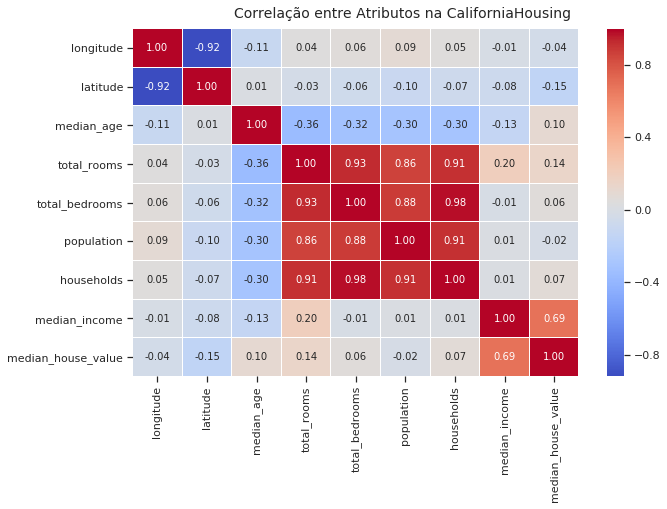

In [31]:
f, ax = plt.subplots(figsize=(10, 6))
corr = df.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Correlação entre Atributos na CaliforniaHousing', fontsize=14)

As variáveis mais correlacionadas com a variável *median_house_value* são *latitude*, *median_age*, *total_rooms* e, principalmente, *median_income*. Os gráficos abaixo ilustram estas correlações.

Text(0.5, 1.03, 'Correlação entre median_house_value e algumas variáveis')

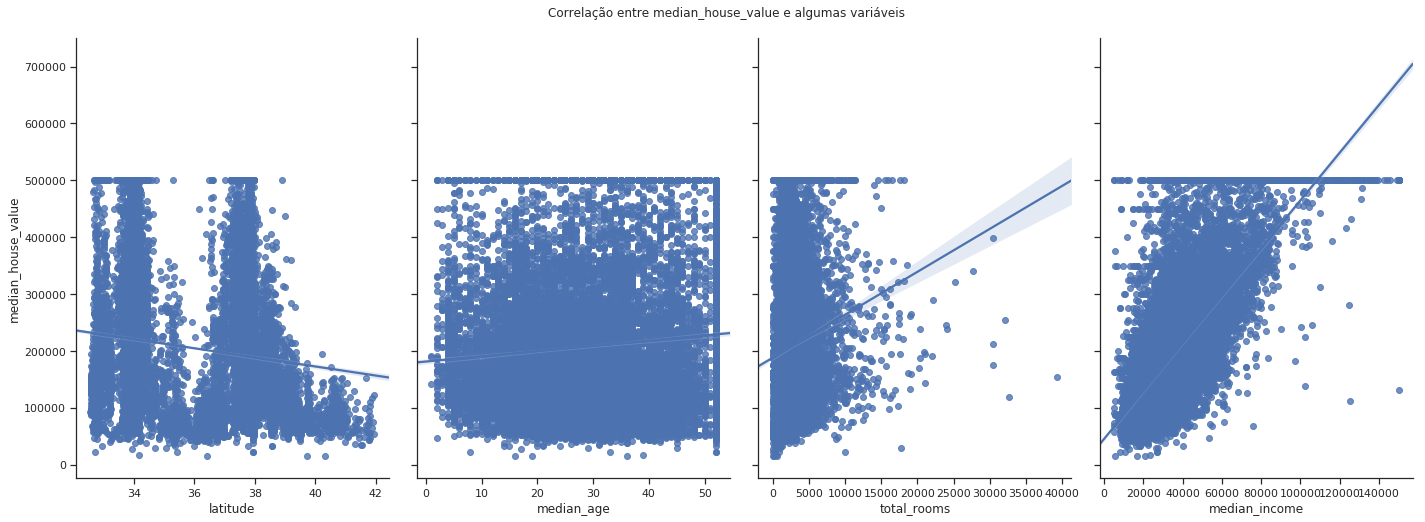

In [32]:
ax = sns.pairplot(df, x_vars=['latitude','median_age','total_rooms','median_income'], 
                         y_vars='median_house_value', height=7, aspect=0.7, kind='reg')

ax.fig.suptitle('Correlação entre median_house_value e algumas variáveis', y=1.03)

A ferramenta a seguir é muito útil para analisar visualmente a relação entre as *features*.

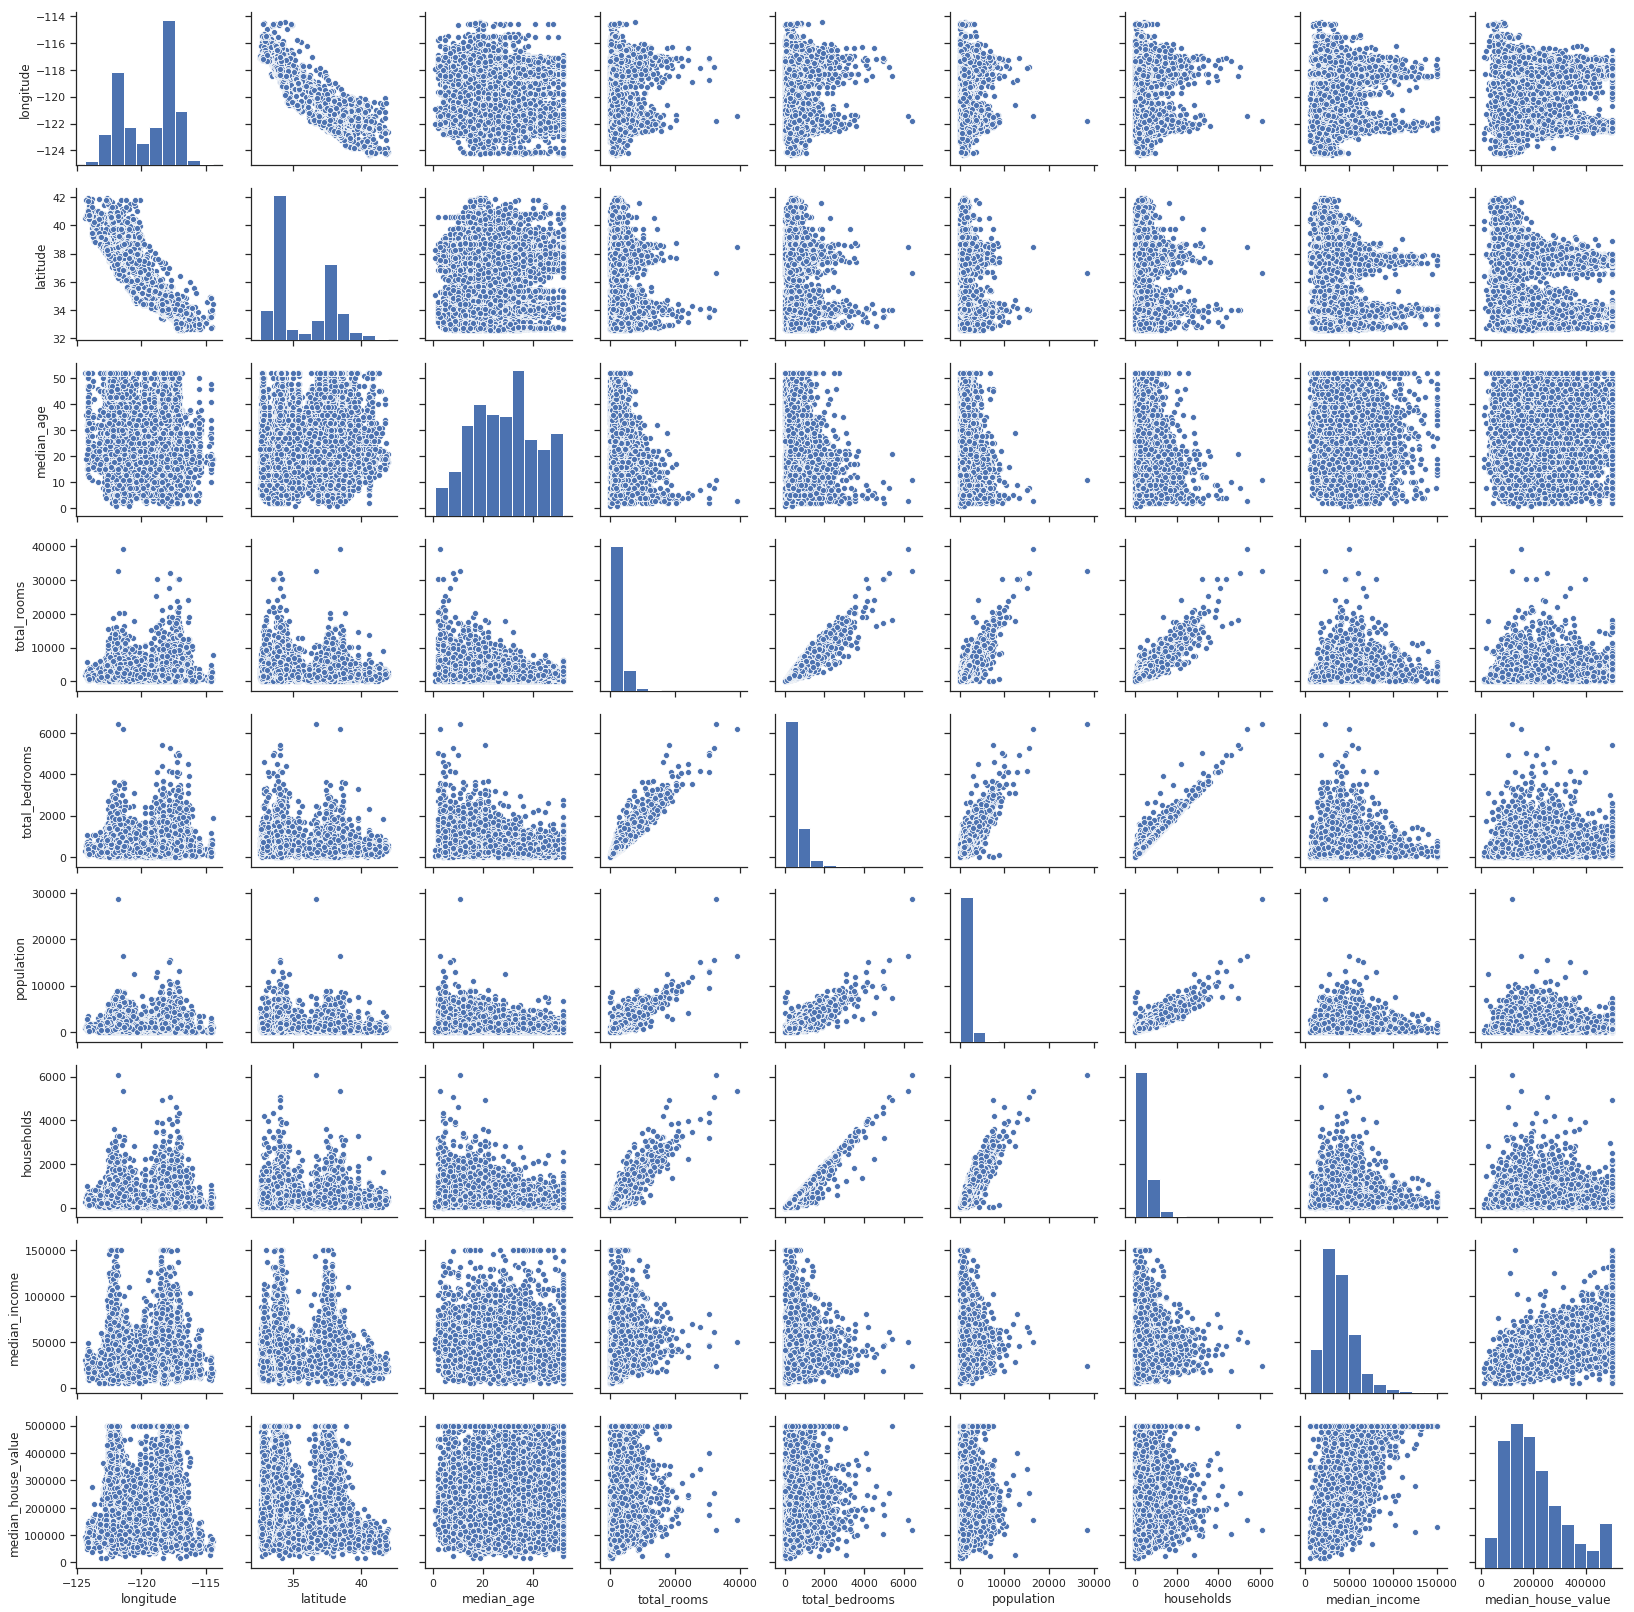

In [33]:
sns.pairplot(df)

A relação entre as variáveis *total_rooms*, *total_bedrooms*, *population* e *households* parece ser aproximadamente linear. Assim, não há ganho de informação em utilizar todas elas para a construção de um modelo preditivo. Além disso, a relação entre latitude e longitude é deveras curiosa. Localizemos espacialmente as casas amostradas.

Text(0.5, 1.0, 'Houses in California')

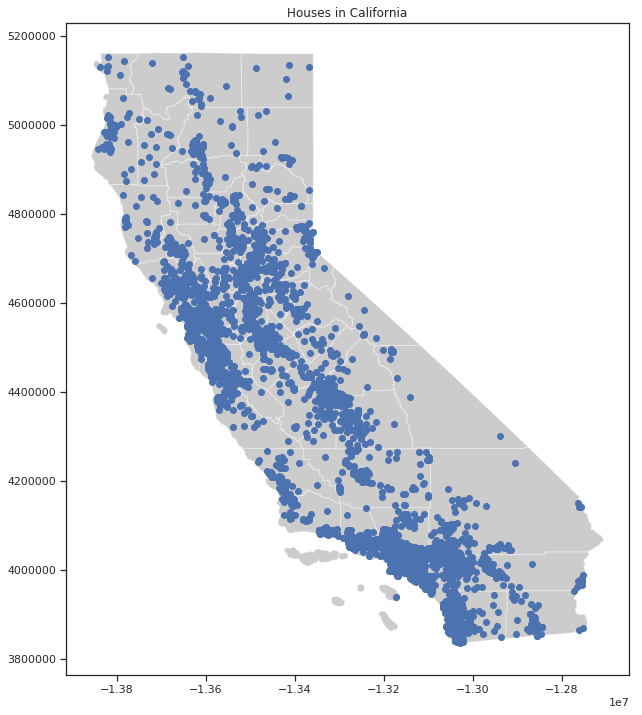

In [34]:
#Importando algumas bibliotecas para analisar dados espaciais
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

#Importando o arquivo shapefile com o mapa da California
calif = gpd.read_file('/kaggle/input/shapefile-california/CA_Counties_TIGER2016.shp')

from pyproj import Proj, transform

#Transformando a latitude e a longitude dos pontos amostrais para o mesmo sistema de referência do mapa da CA
def transforma(x1, y1):
    inProj = Proj(init='epsg:4326')
    outProj = Proj(init='epsg:3857')
    x2,y2 = transform(inProj,outProj,x1,y1)
    return x2, y2

df2 = df.copy()
A = df2.apply(lambda x: transforma(x['longitude'], x['latitude']), axis=1)
#A.to_frame()

#tem jeito menos burro de fazer isso?
long = []
lat = []
for x in A:
    long.append(x[0])
    lat.append(x[1])
long = pd.DataFrame(long)
lat = pd.DataFrame(lat)
df2.longitude = long
df2.latitude = lat

geometry = [Point(xy) for xy in zip (df2['longitude'], df2['latitude'])]
crs = {'init': 'epsg:3857'}

#Transformando o DataFrame em um GeoDataFrame
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)

#Visualizando as casas sobre o mapa
fig, ax = plt.subplots(figsize = (12,12))
calif.plot(ax=ax, alpha=0.4, color='grey')
geo_df.plot(ax=ax)
plt.title("Houses in California")

Antes de passar a modelagem propriamente dita, verifiquemos a distribuição de algumas *features*.

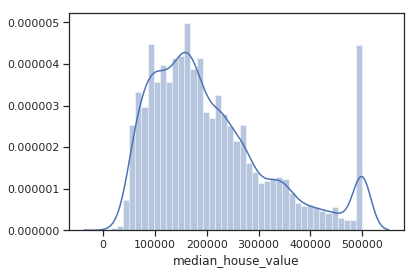

In [35]:
sns.distplot(df.median_house_value)

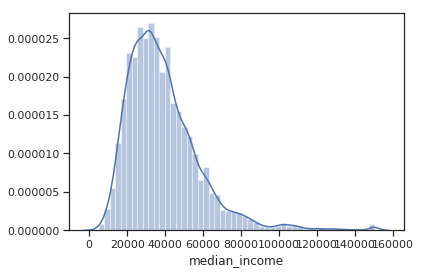

In [36]:
sns.distplot(df.median_income)

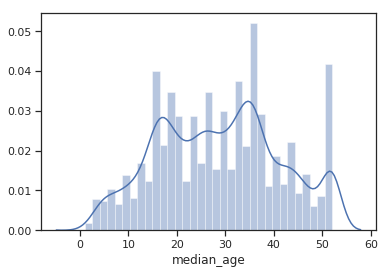

In [37]:
sns.distplot(df.median_age)

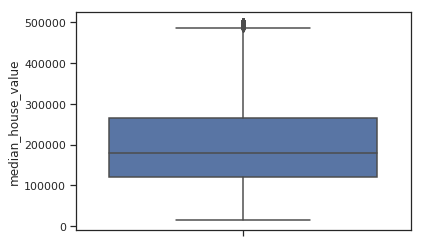

In [38]:
sns.boxplot(df['median_house_value'], orient='v')

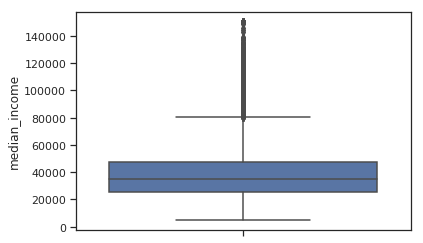

In [39]:
sns.boxplot(df['median_income'], orient='v')

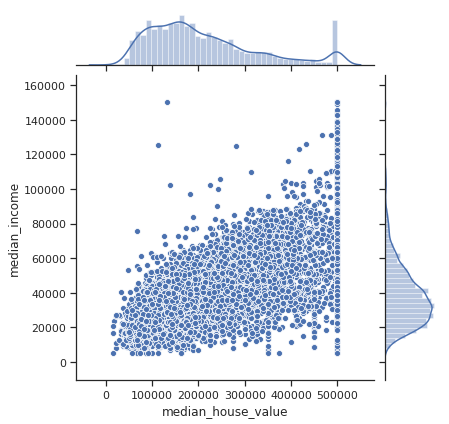

In [40]:
jointgrid = sns.JointGrid(x='median_house_value', y='median_income', data=df)
jointgrid.plot_joint(sns.scatterplot)
jointgrid.plot_marginals(sns.distplot)

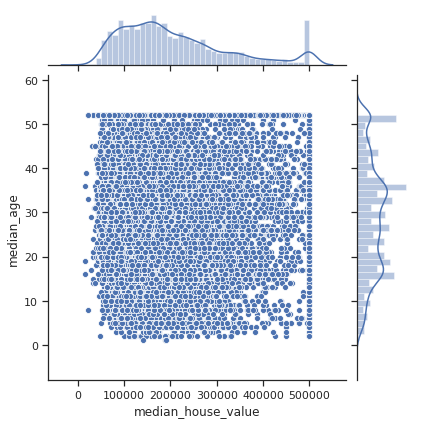

In [41]:
jointgrid = sns.JointGrid(x='median_house_value', y='median_age', data=df)
jointgrid.plot_joint(sns.scatterplot)
jointgrid.plot_marginals(sns.distplot)

### 2. Explorando modelos de regressão ###

Inicialmente, todas as *features* serão utilizadas para treinar os regressores. Em seguida, será feito um estudo acerca das features que minimizam o *Root Mean Squared Logarithmic Error* (RMSLE).

In [42]:
import math
from sklearn.metrics import make_scorer
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

In [43]:
Xtrain = df.iloc[:,:8]
Ytrain = df.iloc[:,8:9]

A função abaixo foi criada para calcular o RMSLE.

In [44]:
def RMSLE(Y, Ypred):
    n = len(Y)
    soma = 0
    Y = np.array(Y)
    for i in range(len(Y)):
        soma += ( math.log( abs(Ypred[i]) + 1 ) - math.log( Y[i] + 1 ) )**2
    return math.sqrt(soma / n)
scorer_rmsle = make_scorer(RMSLE)

Os dados foram ajustados utilizando uma regressão linear simples, uma regressão ridge e uma regressão lasso.

In [45]:
linear = linear_model.LinearRegression()
linear.fit (Xtrain, Ytrain)
scores = cross_val_score (linear, Xtrain, Ytrain, cv = 10, scoring = scorer_rmsle)
total = 0
for j in scores:
    total += j
rmsle_linear = total/10

ridge = linear_model.Ridge (alpha=10000)
ridge.fit (Xtrain,Ytrain)
scores = cross_val_score (ridge,Xtrain,Ytrain, cv = 10,scoring = scorer_rmsle)
total = 0
for j in scores:
    total += j
rmsle_ridge = total/10

lasso = linear_model.Lasso(alpha=10000)
lasso.fit (Xtrain, Ytrain)
scores = cross_val_score (lasso,Xtrain,Ytrain, cv = 10,scoring = scorer_rmsle)
total = 0
for j in scores:
    total += j
rmsle_lasso = total/10

print('RMSLE para regressão linear: ', rmsle_linear, '\nRMSLE para regressão ridge: ', rmsle_ridge, '\nRMSLE para regressão lasso: ', rmsle_lasso)

RMSLE para regressão linear:  0.4247515464685782 
RMSLE para regressão ridge:  0.3873384619306782 
RMSLE para regressão lasso:  0.3953619802961506


O melhor resultado foi obtido para a regressão ridge (usando alpha = 10.000).
A seguir, será gerado um gráfico para nos auxiliar durante a *feature selection*.

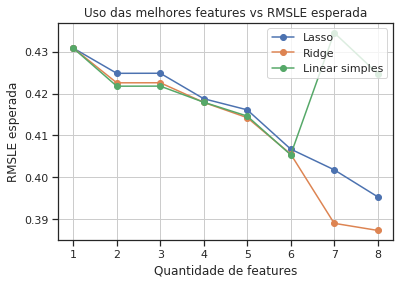

In [46]:
def gerar_grafico(classificadores,X,f_o):
    if X is None:
        acc_total = {}
        for clf in classificadores:
            acc_clf = []
            for n in range(len(f_o)):
                Xn = df[f_o[:n+1]]
                clf.fit(Xn,Ytrain)
                scores = cross_val_score(clf, Xn, Ytrain, cv=10, scoring=scorer_rmsle)
                acc_clf.append(scores.mean())
            acc_total[clf] = acc_clf
    else:
        acc_total = {}
        for clf in  classificadores:
            acc_clf = []
            for n in range(len(f_o)):
                Xn = SelectKBest(chi2, k=n+1).fit_transform(abs(X),Y)
                clf.fit(Xn,Ytrain)
                scores = cross_val_score(clf, Xn, Ytrain, cv=10, scoring=scorer_rmsle)
                acc_clf.append(scores.mean())
            acc_total[clf] = acc_clf
    for clf in acc_total:
        plt.plot(np.arange(1,len(f_o)+1), acc_total[clf], 'o-', label=classificadores[clf])
    plt.ylabel('RMSLE esperada')
    plt.xlabel('Quantidade de features')
    plt.title('Uso das melhores features vs RMSLE esperada')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return acc_total

features_ordenadas = ['median_income','latitude','total_rooms','median_age',
            'households','total_bedrooms','longitude','population']

classificadores_lineares = {lasso:'Lasso',
                            ridge:'Ridge',
                            linear:'Linear simples'}
acc_lineares = gerar_grafico(classificadores_lineares,None,features_ordenadas)

Esperava-se que o RMSLE diminuísse até determinada quantidade de *features* e, a partir daí, começasse a crescer, indicando que acrescentar mais variáveis ao modelo diminui sua acurácia, mas não foi exatamente o que obtemos. Assim sendo, o modelo que mostrou melhor desempenho foi o **regressor ridge**.

In [47]:
test = pd.read_csv('/kaggle/input/californiahousing/test.csv', engine='python', na_values='?')
test.set_index('Id', inplace=True)

Ypredict = ridge.predict(test)

**Obs.:** não foi possível avaliar o regressor na base de testes, já que não foram encontrados os valores de Y reais para comparar com os preditos pelo modelo.